ANCOR

Тестовое задание. Анализ данных и прогнозирование

Вакансия: Junior+ Data Scientist

Кандидат: Андрей Батыров

Язык программирования: Python

Дата: 12-дек-2024

##### <a id="toc"></a>Содержание

[Постановка задачи](#description)

1. [Исходные данные](#data)

2. [Анализ данных](#analysis)
   
   2.1. [EDA](#eda)

   2.2. [Таргет как временной процесс](#time-series)

3. [Построение модели для прогнозирования](#modeling)

    3.1. [Модель линейной регрессии](#linreg)

    3.2. [Модель SARIMAX](#sarimax)

4. [Кросс-валидация](#cross-val)

5. [Прогнозирование](#forecast)

[Итоги](#conclusion)

---
##### <a id="description"></a>Постановка задачи

Данные: 
- Таргет: https://ru.investing.com/commodities/milling-wheat-n2 
- Котировки, которые можно использовать для прогнозирования:
  - https://ru.investing.com/commodities/sge-gold-t-d-cny-cash-spot-futures
  - https://ru.investing.com/commodities/london-gas-oil
  - https://ru.investing.com/commodities/brent-oil
  - https://ru.investing.com/commodities/us-soybean-meal?cid=1178333

Данные можно скачать провалившись в исторические данные. 

Задание:

Основные задачи:
1.	Анализ данных: Провести детальный анализ имеющихся данных, выявить закономерности и тренды, которые могут повлиять на прогноз. Особое внимание нужно уделить факторам, влияющим на цену пшеницы.
2.	Построение модели для прогнозирования: Разработать и обучить модель для прогнозирования цены на пшеницу на три месяца вперед. Таргет - прогноз месячной цены. 

Решение задачи залить в github и прислать ссылку на публичный репозиторий.

[К содержанию](#toc)

---
##### <a id="data"></a>1. Исходные данные

Помесячные данные для активов пшеницы (таргет) и золота, газойля, нефти, сои (возможные внешние регрессоры) были выгружены по указанным ссылкам за максимально доступную глубину и сохранены в отдельных файлах csv.

Поля данных каждого файла:
- Дата
- Цена
- Откр.
- Макс.
- Мин.
- Объём
- Изм. %

В качестве вещественной переменной цены будем использовать поле "Цена". Для каждого актива цена указана в своей валюте: пшеница в EUR, золото в CNY, газойль, нефть и соя в USD. 

In [1]:
# Импортируем необходимые библиотеки и кастомные модули
import warnings
warnings.filterwarnings('ignore', module='statsmodels')
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from scipy.stats import norm
import matplotlib.pyplot as plt
import tqdm
from helper import (describe, 
                    plot_hist, 
                    plot_trace, 
                    plot_pacf, 
                    plot_bar, 
                    plot_decomposition, 
                    plot_goodness, 
                    plot_true_pred_scat, 
                    plot_true_pred_trace, 
                    plot_forecast,
                    run_adf_test)
alpha = 0.05 # уровень стат. значимости

In [2]:
# Загружаем данные и формируем общий датасет
asset_names = ['пшеница', 'золото', 'газойль', 'нефть', 'соя']
date_index = pd.date_range(start='1970-01-01', end='2024-12-01', freq='MS').strftime('%d.%m.%Y')
data = pd.DataFrame(columns=[f'Цена_{_}' for _ in asset_names], index=date_index).reset_index(names='Дата')
for asset_name in asset_names:
    col_name = f'Цена_{asset_name}'
    asset_data = pd.read_csv(f'./data/{asset_name}.csv', 
                             decimal=',', 
                             thousands='.', 
                             usecols=[0, 1], 
                             header=0, 
                             names=['Дата', col_name], 
                             dtype={'Дата': str, col_name: float})
    data = data.merge(asset_data, how='inner', on='Дата', suffixes=('_', '')) # Склеиваем csv в общий датафрейм
data = data.dropna(axis=1, how='all')
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.reset_index(names='Дата_idx') # Индекс даты
data = data.set_index('Дата')
data = data.asfreq('MS') # Каждая дата - начало месяца
data.shape

(244, 6)

In [3]:
print(f'Диапазон дат: {data.index.min()} -- {data.index.max()}')

Диапазон дат: 2004-09-01 00:00:00 -- 2024-12-01 00:00:00


In [4]:
data.dtypes

Дата_idx          int64
Цена_пшеница    float64
Цена_золото     float64
Цена_газойль    float64
Цена_нефть      float64
Цена_соя        float64
dtype: object

In [5]:
# Проверяем наличие пропущенных значений
data.isna().sum()

Дата_idx        0
Цена_пшеница    0
Цена_золото     0
Цена_газойль    0
Цена_нефть      0
Цена_соя        0
dtype: int64

In [6]:
data

,Дата_idx,Цена_пшеница,Цена_золото,Цена_газойль,Цена_нефть,Цена_соя
Дата,,,,,,
2004-09-01,0,108.50,108.73,429.25,46.38,161.1
2004-10-01,1,108.50,112.85,437.50,48.98,157.9
2004-11-01,2,107.50,119.07,427.50,45.51,157.3
2004-12-01,3,106.00,116.94,365.25,40.46,165.0
2005-01-01,4,107.25,113.10,393.25,45.92,155.3
...,...,...,...,...,...,...
2024-08-01,239,205.75,573.59,696.50,76.93,313.0
2024-09-01,240,222.25,595.25,659.50,71.70,341.9
2024-10-01,241,218.00,634.00,669.00,73.16,304.0


[К содержанию](#toc)

---
##### <a id="analysis"></a>2. Анализ данных

<a id="eda"></a>2.1. EDA

r = 0.55
0 nulls
Min = 101.50
Max = 400.75
Med = 187.50


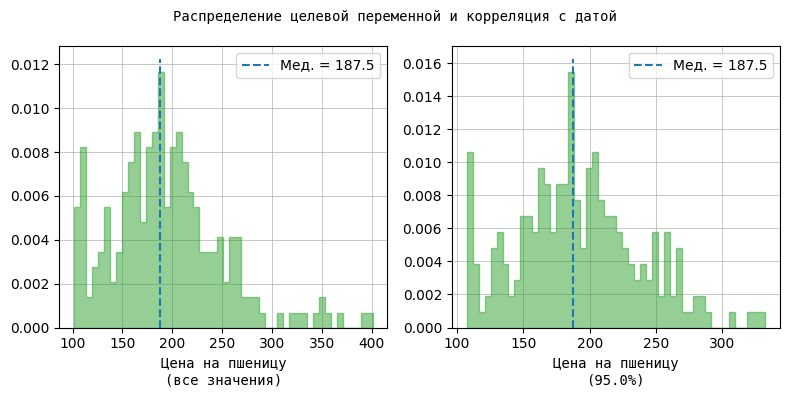

In [7]:
# Таргет
target = 'Цена_пшеница'
print(f"r = {np.corrcoef(data['Дата_idx'], data[target].values)[0, 1]:.2f}")
describe(data[target], 'num')
plot_hist(data[target].values, None, 50, 95.0, 'Цена на пшеницу', 'Распределение целевой переменной и корреляция с датой')

r = 0.60
0 nulls
Min = 108.73
Max = 634.00
Med = 273.84


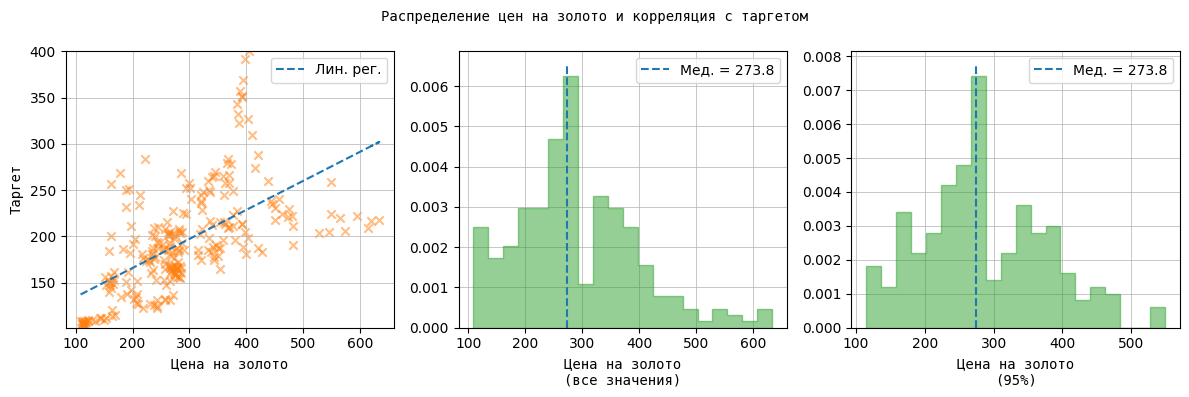

In [8]:
# Золото
print(f"r = {data['Цена_золото'].corr(data[target]):.2f}")
describe(data['Цена_золото'], 'num')
plot_hist(data['Цена_золото'].values, data[target].values, 20, 95, 'Цена на золото', 'Распределение цен на золото и корреляция с таргетом')

r = 0.61
0 nulls
Min = 236.75
Max = 1,268.50
Med = 637.88


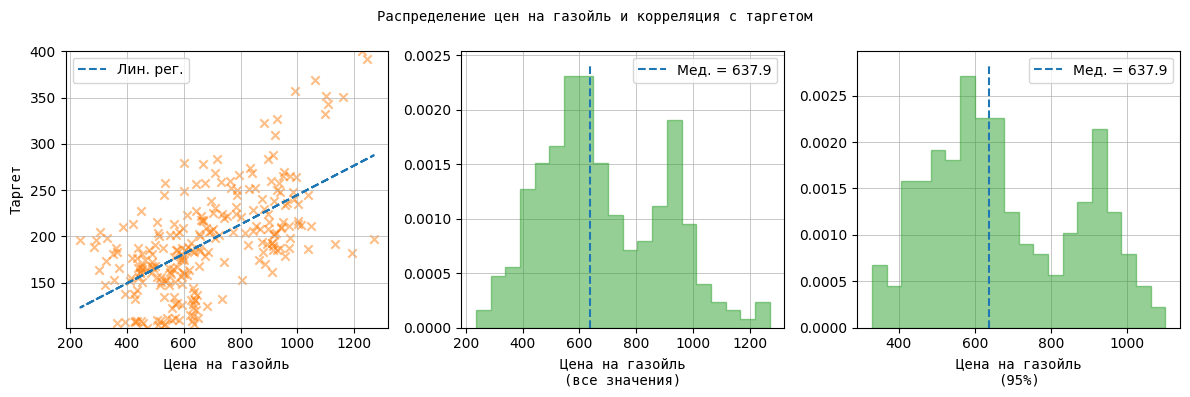

In [9]:
# Газойль
print(f"r = {data['Цена_газойль'].corr(data[target]):.2f}")
describe(data['Цена_газойль'], 'num')
plot_hist(data['Цена_газойль'].values, data[target].values, 20, 95, 'Цена на газойль', 'Распределение цен на газойль и корреляция с таргетом')

r = 0.51
0 nulls
Min = 26.35
Max = 139.83
Med = 72.66


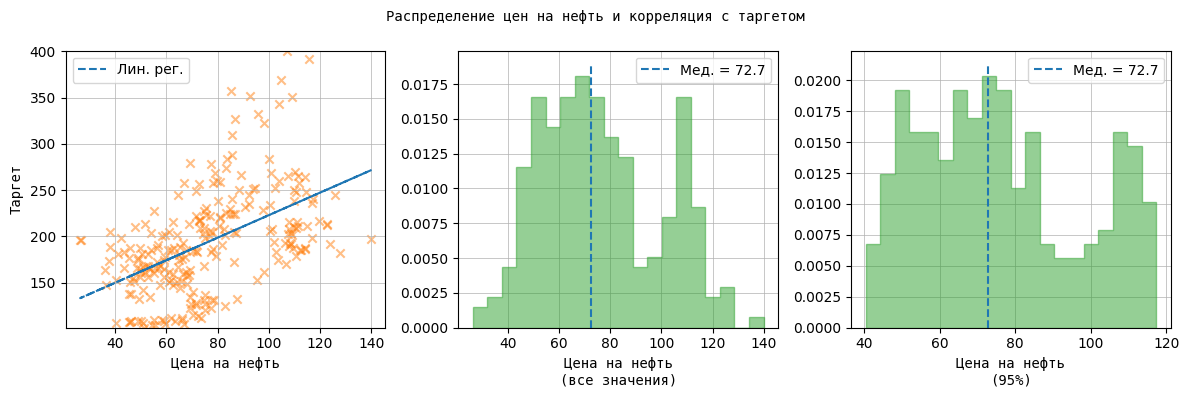

In [10]:
# Нефть
print(f"r = {data['Цена_нефть'].corr(data[target]):.2f}")
describe(data['Цена_нефть'], 'num')
plot_hist(data['Цена_нефть'].values, data[target].values, 20, 95, 'Цена на нефть', 'Распределение цен на нефть и корреляция с таргетом')

r = 0.73
0 nulls
Min = 155.30
Max = 533.40
Med = 323.15


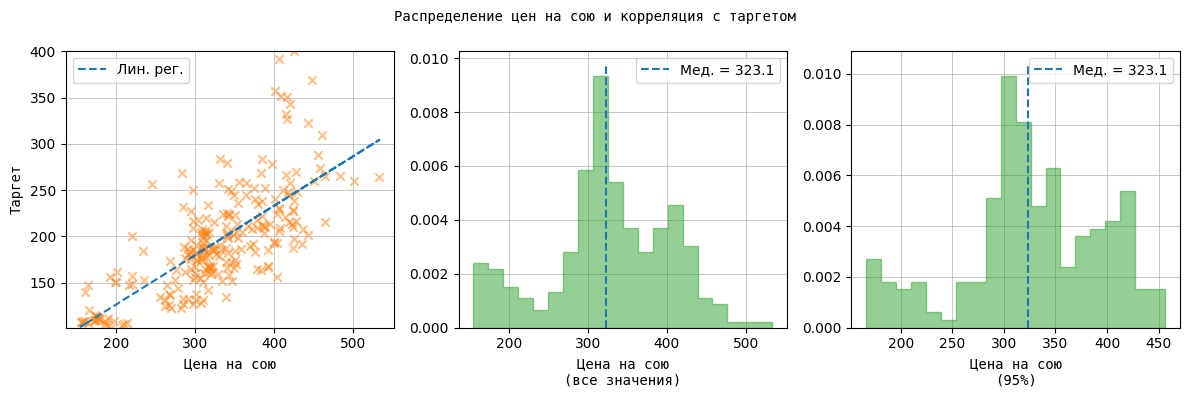

In [11]:
# Соя
print(f"r = {data['Цена_соя'].corr(data[target]):.2f}")
describe(data['Цена_соя'], 'num')
plot_hist(data['Цена_соя'].values, data[target].values, 20, 95, 'Цена на сою', 'Распределение цен на сою и корреляция с таргетом')

In [12]:
# Матрица линейной корреляции
corr_df = data.drop(columns=['Дата_idx']).corr()
corr_df = corr_df.where(np.identity(corr_df.shape[0]) != 1.0, np.nan) # Исключаем из отчета корреляцию метрики с самой собой
(corr_df
    .style.format(na_rep='-', formatter=lambda x: f'{x:.2f}')
    .highlight_between(left=0.5, right=1.0, color='palegreen')
    .highlight_between(right=-0.5, left=-1.0, color='palegreen')
    .highlight_between(left=0.9, right=1.0, color='yellow')
    .highlight_between(right=-0.9, left=-1.0, color='yellow')
    .set_caption(f'<h4>Матрица корреляции для всех переменных</h4>')
)

,Цена_пшеница,Цена_золото,Цена_газойль,Цена_нефть,Цена_соя
Цена_пшеница,-,0.60,0.61,0.51,0.73
Цена_золото,0.60,-,0.26,0.20,0.58
Цена_газойль,0.61,0.26,-,0.96,0.56
Цена_нефть,0.51,0.20,0.96,-,0.54
Цена_соя,0.73,0.58,0.56,0.54,-


[К содержанию](#toc)

<a id="time-series"></a>2.2. Таргет как на временной процесс

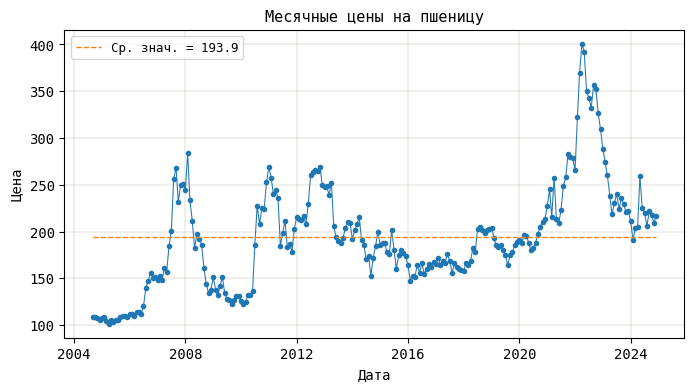

In [13]:
plot_trace(data, target, 'Дата', 'Цена', 'Месячные цены на пшеницу')

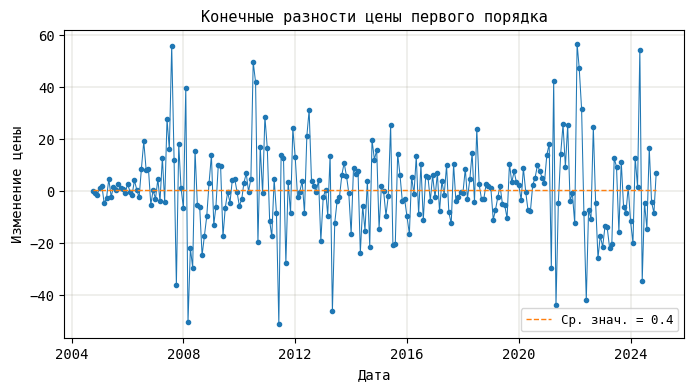

In [14]:
plot_trace(data.diff().dropna(), target, 'Дата', 'Изменение цены', 'Конечные разности цены первого порядка')

Несмотря на то, что визуально цена подвержена сильным колебаниям от среднего значения, конечные разности колеблются около нуля.

Проверим стационарность с помощью расширенного теста Дики - Фуллера (ADF).

$\mathcal{H}_{0}$: временной ряд нестационарен

$\mathcal{H}_{1}$: временной ряд стационарен

In [15]:
print('Цена пшеницы:           ', end='')
run_adf_test(data, target, alpha)
print('Конечные разности цены: ', end='')
run_adf_test(data.diff().dropna(), target, alpha)

Цена пшеницы:           adf_stats =  -3.28, adf_pval = 0.02, Стационарен для alpha = 0.05
Конечные разности цены: adf_stats = -15.05, adf_pval = 0.00, Стационарен для alpha = 0.05



Дополнительно посмотрим на коррелограмму таргета на год (12 месяцев) с помощью частичной автокорреляционной функции.

PACF(1) = 0.96


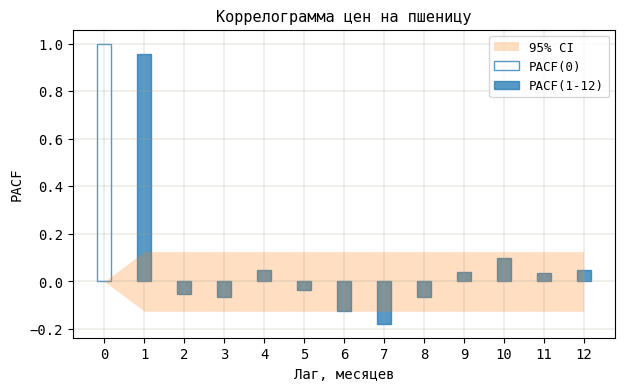

In [16]:
plot_pacf(data, target, 12, alpha, 'Лаг, месяцев', 'Коррелограмма цен на пшеницу')

На коррелограмме видно, что цена в текущем месяце сильно коррелированна с ценой за предыдущий месяц с коэффициентом корреляции 0.96.

Наконец, проверим наличие сезонной составляющей в цене пшеницы. Ожидаемо, пшеница - сезонный товар, связанный с особенностями товара и организацией сельского хозяйства. Оценим сезонность с периодом в один год (12 месяцев).

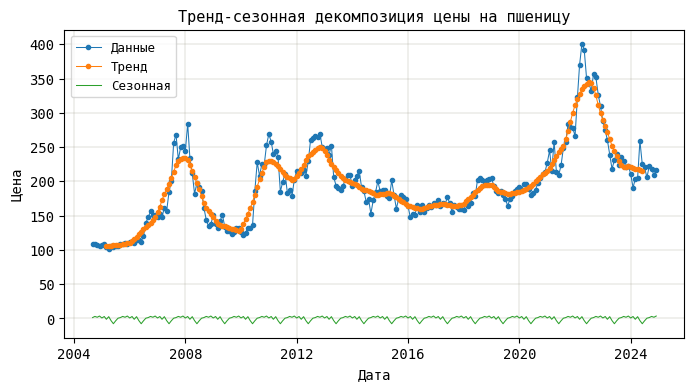

In [17]:
decompose_result = plot_decomposition(data, target, 12, 'Дата', 'Цена', 'Тренд-сезонная декомпозиция цены на пшеницу')

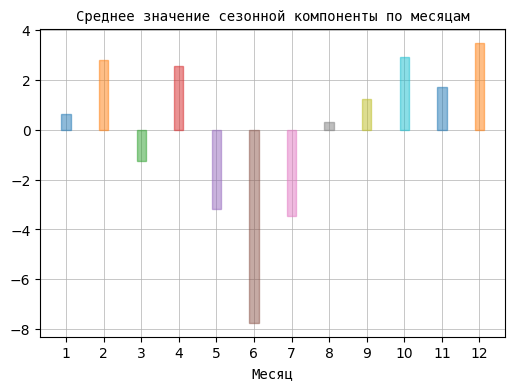

In [18]:
season_df = pd.DataFrame(decompose_result.seasonal.groupby(decompose_result.seasonal.index.month).mean())\
    .reset_index()\
    .rename(columns={'Дата': 'Месяц', 'seasonal': 'Сред'})
plot_bar(season_df, 'Месяц', 'Сред', 'Месяц', 'Среднее значение сезонной компоненты по месяцам')

Отметим, что среднемесячные сезонные компоненты таргета ниже в теплое время года (в северном полушарии).

Выводы:
- Цена пшеницы линейно-положительна коррелированна с внешними факторами ($r \ge 0.5$);
- Цены на нефть и газойль сильно коррелированны, что позволяет использовать только один признак для исключения коллинеарности;
- Т.к. корреляция цены пшеницы с газойлем выше, чем с нефтью, отбросим нефть и оставим газойль;
- Цена пшеницы и конечные разности первого порядка стационарны;
- Обнаружена сильная авторегрессия первого порядка;
- В цене присутствует сезонная составляющая, в частности с периодом 12 месяцев.

Таким образом, будущую модель будем строить на таких данных:
- Цена пшеницы (таргет);
- Цены золота, газойля, сои (внешние факторы);
- Модель должна рассматривать таргет как временной процесс.

In [19]:
data = data.drop('Цена_нефть', axis=1)
data

,Дата_idx,Цена_пшеница,Цена_золото,Цена_газойль,Цена_соя
Дата,,,,,
2004-09-01,0,108.50,108.73,429.25,161.1
2004-10-01,1,108.50,112.85,437.50,157.9
2004-11-01,2,107.50,119.07,427.50,157.3
2004-12-01,3,106.00,116.94,365.25,165.0
2005-01-01,4,107.25,113.10,393.25,155.3
...,...,...,...,...,...
2024-08-01,239,205.75,573.59,696.50,313.0
2024-09-01,240,222.25,595.25,659.50,341.9
2024-10-01,241,218.00,634.00,669.00,304.0


[К содержанию](#toc)

---
##### <a id="modeling"></a>3. Построение модели прогнозирования

<a id="linreg"></a>3.1. Модель линейной регрессии

Выше мы получили "хорошие" коэффициенты корреляции цены пшеницы с датой и ценами на другие активы. Попробуем построить базовую линейную регрессионную модель цены, т.е. пока без учета временного процесса.

In [20]:
model_lr = smf.ols(f"{target} ~ {' + '.join(data.drop(target, axis=1).columns)}", data=data)
fitted_lr = model_lr.fit()

In [21]:
# Результаты обучения
print(fitted_lr.summary())

                            OLS Regression Results                            
Dep. Variable:           Цена_пшеница   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     122.6
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           1.01e-56
Time:                        17:47:27   Log-Likelihood:                -1192.2
No. Observations:                 244   AIC:                             2394.
Df Residuals:                     239   BIC:                             2412.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.1171      9.839      1.435   

Рассчитаем метрики модели.

In [22]:
print('Статистически значимые параметры модели:')
print(fitted_lr.params[fitted_lr.pvalues <= alpha].to_string())

Статистически значимые параметры модели:
Дата_idx        0.286203
Цена_газойль    0.113811
Цена_соя        0.199074


In [23]:
print(f'R2   = {fitted_lr.rsquared:>5.2f}')
print(f"RMSE = {root_mean_squared_error(data[target], fitted_lr.predict(data.drop(target, axis=1))):>5.2f}")
print(f"MAE  = {mean_absolute_error(data[target], fitted_lr.predict(data.drop(target, axis=1))):>5.2f}")

R2   =  0.67
RMSE = 32.04
MAE  = 25.14


In [24]:
print(f'DW = {durbin_watson(fitted_lr.resid):.2f}')

DW = 0.25


Выводы:
- не все параметры модели получились статистически значимыми;
- также обратим внимание на статистику Дарбина - Уотсона для остатков модели: $DW = 0.25 < 2$, что свидетельствует о позитивной автокорреляции первого порядка - такую автокорреляцию мы также обнаружили при анализе выше. Наличие автокорреляции нарушает одно из условий использования модели линейной регрессии: независимость наблюдений (цен) между собой (i.i.d.).

Таким образом, линейная регрессионная модель в данном случае неприменима.

[К содержанию](#toc)

<a id="sarimax"></a>3.2. Модель SARIMAX

В качестве более подходящей выберем модель SARIMAX - Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors.

Данная линейная модель позволит учесть:
- сезонную составляющую цены;
- автокорреляцию цены;
- нестационарность цены: несмотря на то, что мы подтвердили стационарность, используем эту особенность модели для большей робастности;
- внешние факторы (экзогенные регрессоры), такие как цены на другие активы.

Модель имеет следующие параметры:
- P - порядок сезонной автокорреляции (SAR);
- D - порядок сезонного дифференцирования (SI);
- Q - порядок сезонного скользящего среднего (SMA).
- s - период сезонности;
- p - порядок несезонной автокорреляции (AR);
- d - порядок несезонного дифференцирования (I);
- q - порядок несезонного скользящего среднего (MA).

Разделим наши данные на 2 выборки:
- train_val_df для обучения и внутривыборочной (in-sample) валидации модели;
- forecast_df для вневыборочного (out-of-sample) прогноза модели.

In [25]:
train_val_df = data.loc[: '2024-09-01']
forecast_df = data.loc['2024-10-01':] # 3 последних месяца
print(f'Диапазон дат для обучения и валидации: {train_val_df.index.min()} -- {train_val_df.index.max()}')
print(f'Диапазон дат для прогнозирования:      {forecast_df.index.min()} -- {forecast_df.index.max()}')

Диапазон дат для обучения и валидации: 2004-09-01 00:00:00 -- 2024-09-01 00:00:00
Диапазон дат для прогнозирования:      2024-10-01 00:00:00 -- 2024-12-01 00:00:00


In [26]:
train_val_df

,Дата_idx,Цена_пшеница,Цена_золото,Цена_газойль,Цена_соя
Дата,,,,,
2004-09-01,0,108.50,108.73,429.25,161.1
2004-10-01,1,108.50,112.85,437.50,157.9
2004-11-01,2,107.50,119.07,427.50,157.3
2004-12-01,3,106.00,116.94,365.25,165.0
2005-01-01,4,107.25,113.10,393.25,155.3
...,...,...,...,...,...
2024-05-01,236,259.25,549.50,731.75,355.9
2024-06-01,237,224.75,549.30,785.50,335.7
2024-07-01,238,220.25,564.16,740.25,314.1


In [27]:
forecast_df

,Дата_idx,Цена_пшеница,Цена_золото,Цена_газойль,Цена_соя
Дата,,,,,
2024-10-01,241,218.0,634.0,669.00,304.0
2024-11-01,242,209.5,614.6,677.00,297.6
2024-12-01,243,216.5,619.2,669.62,298.0


Подберем оптимальные параметры модели перебором всех возможных кортежей (декартовых произведений значений параметров). В качестве метрики оптимальности модели будем минимизировать AIC (Akaike Information Criterion) - он лучше оценивает предсказательные возможности модели.

In [28]:
Ps, ps = range(0, 2), range(0, 2)
Ds, ds = range(1, 2), range(1, 2)
Qs, qs = range(0, 2), range(0, 2)
param_prods = list(product(Ps, ps, Ds, ds, Qs, qs))
print(f'Кол-во кортежей параметров: {len(param_prods)}')

Кол-во кортежей параметров: 16


In [29]:
best_aic = float('inf')
best_order, best_seasonal_order = None, None
for P, p, D, d, Q, q in tqdm.tqdm(param_prods):
    model_sarimax = SARIMAX(endog=train_val_df[target], 
                            exog=train_val_df.drop(columns=[target, 'Дата_idx']), 
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 12)) # период сезонности 12 месяцев
    fitted_sarimax = model_sarimax.fit()
    aic = fitted_sarimax.aic
    if aic < best_aic:
        best_aic = aic
        best_order = (p, d, q)
        best_seasonal_order = (P, D, Q)

100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


In [30]:
print(f'Лучший кортеж несезонных параметров: {best_order}')
print(f'Лучший кортеж сезонных параметров: {best_seasonal_order}')

Лучший кортеж несезонных параметров: (0, 1, 0)
Лучший кортеж сезонных параметров: (0, 1, 1)


Повторно обучаем с оптимизированными параметрами.

In [31]:
model_sarimax = SARIMAX(endog=train_val_df[target], 
                        exog=train_val_df.drop(columns=[target, 'Дата_idx']), 
                        order=best_order,
                        seasonal_order=best_seasonal_order + (12,))
fitted_sarimax = model_sarimax.fit()

In [32]:
# Результаты обучения
print(fitted_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Цена_пшеница   No. Observations:                  241
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -956.862
Date:                              Thu, 12 Dec 2024   AIC                           1923.724
Time:                                      17:47:41   BIC                           1940.871
Sample:                                  09-01-2004   HQIC                          1930.642
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Цена_золото     -0.0121      0.094     -0.129      0.897      -0.196       0.172
Цена_газойль 

Рассчитаем метрики модели.

In [33]:
print('Статистически значимые параметры модели:')
print(fitted_sarimax.params[fitted_sarimax.pvalues <= alpha].to_string())

Статистически значимые параметры модели:
Цена_соя      0.245701
ma.S.L12     -0.892188
sigma2      238.064634


In [34]:
print(f'R2   = {r2_score(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')
print(f'RMSE = {root_mean_squared_error(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')
print(f'MAE  = {mean_absolute_error(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')

R2   =  0.92
RMSE = 16.05
MAE  = 11.72


Оценим корреляцию между предсказанными и фактическими ценами.

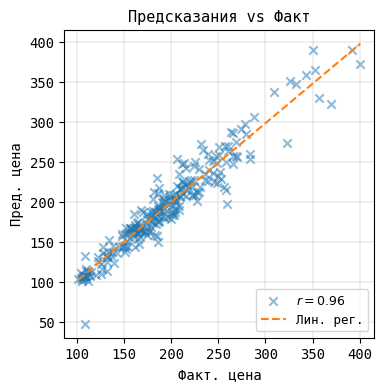

In [35]:
plot_true_pred_scat(train_val_df[target], fitted_sarimax.fittedvalues, 'Факт. цена', 'Пред. цена')

Оценим остатки предсказаний модели.

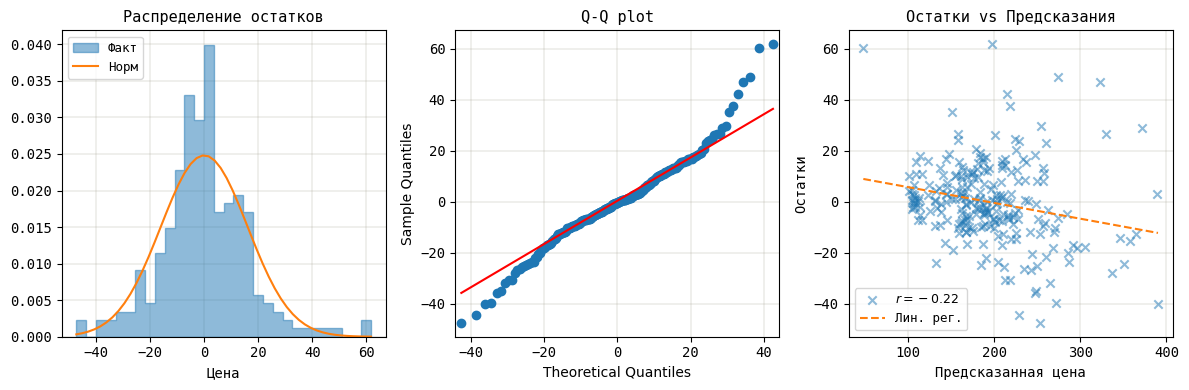

In [36]:
plot_goodness(train_val_df[target], fitted_sarimax.fittedvalues, 'Цена', 'Предсказанная цена', 'Остатки')

Оценим визуально внутривыборочные (in-sample) предсказания модели, например, за последние 5 лет.

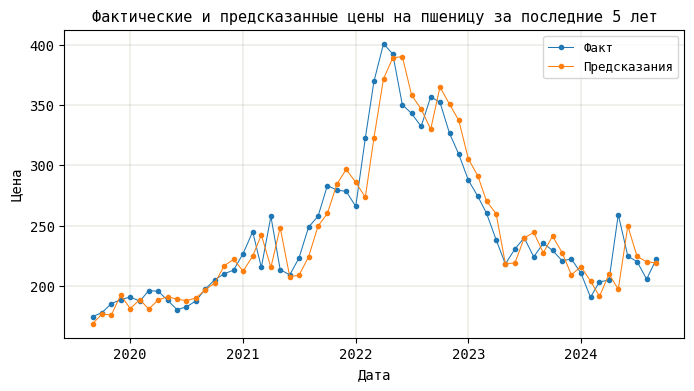

In [37]:
plot_true_pred_trace(train_val_df.loc['2019-09-01':].index, 
                  train_val_df.loc['2019-09-01':][target], 
                  fitted_sarimax.fittedvalues['2019-09-01':], 
                  'Дата', 
                  'Цена', 
                  'Фактические и предсказанные цены на пшеницу за последние 5 лет')

Выводы:
- построенная модель имеет высокий $R^2 = 0.92$, т.е. хорошо объясняет дисперсию цены на пшеницу в зависимости от даты и внешних факторов;
- статистически значимым внешним фактором является цена на сою;
- распределение остатков модели имеет выбросы;
- остатки имеют слабую, но не нулевую гетероскедастичность - коэф. корр. остатков с предсказанной ценой $r = -0.22$. Возможно, это связано с режимами с высокой волатильностью - это заметно и на временной диаграмме выше.

[К содержанию](#toc)

---
##### <a id="cross-val"></a>4. Кросс-валидация

После построения модели мы хотим убедиться в ее устойчивости на разных временных интервалах для внутривыборочных данных (in-sample). Для этого проведем кросс-валидацию на 10 различных пересекающихся временных интервалах методом скользящего окна. Для корректного разделения временных данных на выборки воспользуемся объектом TimeSeriesSplit из библиотеки sklearn.

In [38]:
n_windows = 10 # Кол-во скользящих окон
ts_cv_sv_base = TimeSeriesSplit(n_splits=n_windows, max_train_size=train_val_df.shape[0] - n_windows, test_size=1, gap=0)

In [39]:
print('Окно # | Диапазон дат             | Месяцев (примерно)')
print('-------|--------------------------|-------------------')
for i, split in enumerate(ts_cv_sv_base.split(train_val_df)):
    train_start = train_val_df.iloc[split[0]].index.min().date()
    train_end = train_val_df.iloc[split[0]].index.max().date()
    print(f'{i + 1:>6} | {train_start} -- {train_end} | {(train_end - train_start).days // 30 + 1}')

Окно # | Диапазон дат             | Месяцев (примерно)
-------|--------------------------|-------------------
     1 | 2004-09-01 -- 2023-11-01 | 234
     2 | 2004-10-01 -- 2023-12-01 | 234
     3 | 2004-11-01 -- 2024-01-01 | 234
     4 | 2004-12-01 -- 2024-02-01 | 234
     5 | 2005-01-01 -- 2024-03-01 | 234
     6 | 2005-02-01 -- 2024-04-01 | 234
     7 | 2005-03-01 -- 2024-05-01 | 234
     8 | 2005-04-01 -- 2024-06-01 | 234
     9 | 2005-05-01 -- 2024-07-01 | 234
    10 | 2005-06-01 -- 2024-08-01 | 234


In [40]:
cv_results_df = pd.DataFrame(columns=['Даты', 'R2', 'RMSE', 'MAE'])

In [41]:
for split in ts_cv_sv_base.split(train_val_df):
    train_start = train_val_df.iloc[split[0]].index.min().date()
    train_end = train_val_df.iloc[split[0]].index.max().date()
    model_sarimax = SARIMAX(endog=train_val_df.loc[train_start: train_end][target], 
                            exog=train_val_df.loc[train_start: train_end].drop(columns=[target, 'Дата_idx']), 
                            order=best_order,
                            seasonal_order=best_seasonal_order + (12,))
    fitted_sarimax = model_sarimax.fit()
    r2 = r2_score(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    rmse = root_mean_squared_error(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    mae = mean_absolute_error(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    cv_results_df.loc[len(cv_results_df)] = [f'{train_start} -- {train_end}', r2, rmse, mae]

In [42]:
cv_results_df

,Даты,R2,RMSE,MAE
0,2004-09-01 -- 2023-11-01,0.924296,15.724438,11.526782
1,2004-10-01 -- 2023-12-01,0.922686,15.824752,11.643585
2,2004-11-01 -- 2024-01-01,0.921902,15.831236,11.685557
3,2004-12-01 -- 2024-02-01,0.920480,15.894299,11.779948
4,2005-01-01 -- 2024-03-01,0.920038,15.854684,11.829141
5,2005-02-01 -- 2024-04-01,0.920634,15.713376,11.802363
6,2005-03-01 -- 2024-05-01,0.915735,16.153684,12.021346
7,2005-04-01 -- 2024-06-01,0.914505,16.185343,12.064196
8,2005-05-01 -- 2024-07-01,0.913128,16.217982,12.131935
9,2005-06-01 -- 2024-08-01,0.911346,16.287748,12.220461


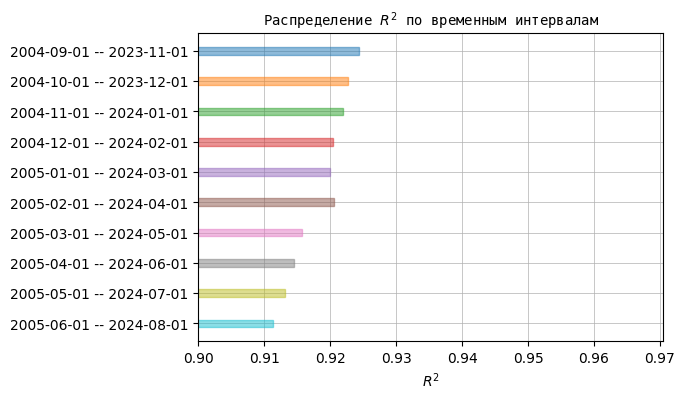

In [43]:
plot_bar(cv_results_df, 'Даты', 'R2', '$R^2$', 'Распределение $R^2$ по временным интервалам', 'horizontal', 0.9)

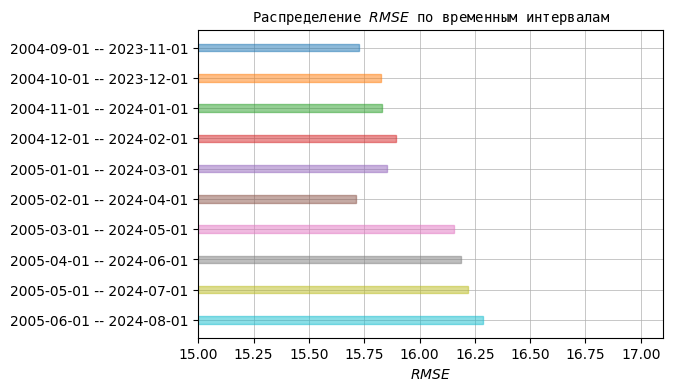

In [44]:
plot_bar(cv_results_df, 'Даты', 'RMSE', '$RMSE$', 'Распределение $RMSE$ по временным интервалам', 'horizontal', 15.0)

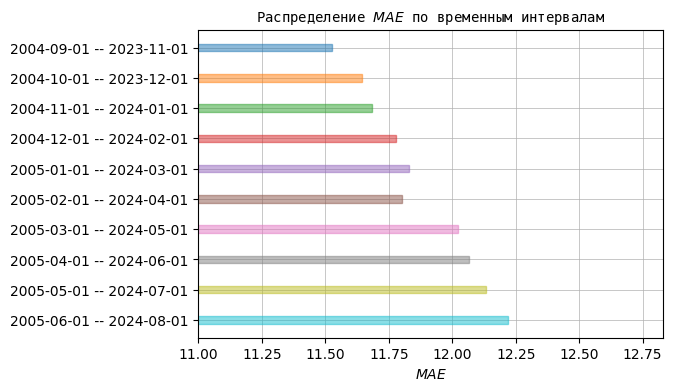

In [45]:
plot_bar(cv_results_df, 'Даты', 'MAE', '$MAE$', 'Распределение $MAE$ по временным интервалам', 'horizontal', 11.0)

Выводы:
- в целом, метрики модели устойчивы на разных временных интервалах;
- наблюдается тенденция к ухудшению метрик для выборок с марта 2005 года до сентября 2024 года (конец обучающей выборки).

Будем считать построенную модель пригодной для прогнозирования.

[К содержанию](#toc)

---
##### <a id="forecast"></a>5. Прогнозирование

Спрогнозируем цены на пшеницу на 3 месяца вперед. Т.к. в модели используются экзогенные регрессоры, проведем прогнозирование для месяцев с известными значениями этих регрессоров, т.е. октябрь, ноябрь, декабрь 2024 года (out-of-sample выборка).

Предварительно повторно обучим модель после кросс-валидации на внутривыборочных данных (in-sample).

In [46]:
model_sarimax = SARIMAX(endog=train_val_df[target], 
                        exog=train_val_df.drop(columns=[target, 'Дата_idx']), 
                        order=best_order,
                        seasonal_order=best_seasonal_order + (12,))
fitted_sarimax = model_sarimax.fit()

Составляем прогноз для вневыборочных данных (out-of-sample).

In [47]:
forecast_sarimax = fitted_sarimax.get_forecast(steps=3, exog=forecast_df.drop(columns=[target, 'Дата_idx']))

Фактические и спрогнозированные цены на пшеницу на 3 месяца.

In [48]:
forecast_mean = forecast_sarimax.predicted_mean
forecast_ci = forecast_sarimax.conf_int(alpha=alpha)
forecast_result_df = pd.concat([forecast_df[target], forecast_mean, forecast_ci], axis=1)
forecast_result_df.columns = ['Цена_факт', 'Цена_прогноз', 'Цена_прогноз_нижн', 'Цена_прогноз_верх']
forecast_result_df

,Цена_факт,Цена_прогноз,Цена_прогноз_нижн,Цена_прогноз_верх
2024-10-01,218.0,213.682614,183.409167,243.956061
2024-11-01,209.5,210.065380,167.252260,252.878499
2024-12-01,216.5,208.215164,155.780015,260.650312


Оценим визуально результаты прогнозирования.

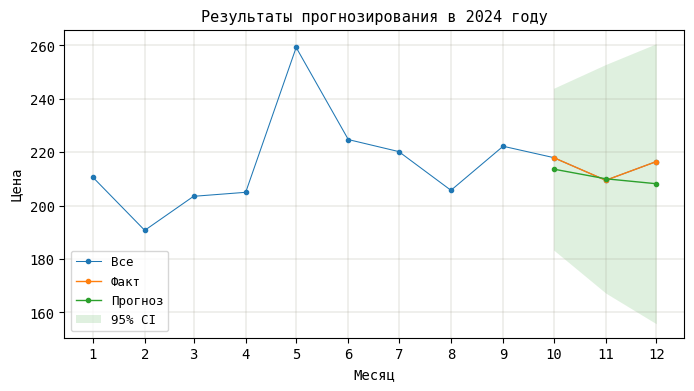

In [49]:
plot_forecast(data.loc['2024-01-01':], 
              forecast_df, 
              forecast_mean, 
              forecast_ci, 
              target, 
              1.0 - alpha, 
              'Месяц', 
              'Цена', 
              'Результаты прогнозирования в 2024 году')

Выводы:
- Получили прогноз на 3 месяца;
- Фактические цены на пшеницу лежат внутри 95% доверительного интервала прогнозов модели.

[К содержанию](#toc)

---
##### <a id="conclusion"></a>Итоги

- Провели тщательный анализ цены на пшеницу как функции от даты и внешних факторов, включая корреляцию и тренд-сезонную декомпозицию;
- Проверили и показали невозможность использования простой линейное модели;
- Разработали и валидировали более сложную и робастную прогностическую модель с хорошими метриками;
- Составили прогноз цены на 3 месяца. Результаты прогноза соответствуют фактическим ценам.
- В качестве развития модели можно предложить использовать дополнительные внешние регрессоры, такие как температура и влажность воздуха. Для этого необходима информация, в каком регионе и в какое время года внешние регрессоры могут оказывать влияние на производство и цену пшеницы.

[К содержанию](#toc)